# IBM Data Science - Capstone Project

# Topic: Clustering Similar Areas in New York City and London

## Introduction
First of all, I will process the latitude and longitude values found on web. I am going to use the Foursquare API to explore areas in New York City and London. Then, I will use K-Mean Clustering Algorithm to cluster areas both in New York and London at the same time in order to find out the similar clusters in both of the cities.

Import the libraries that need to be used:

In [2]:
import numpy as np # library to handle data in a vectorized manner

import pandas as pd # library for data analsysis
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import json # library to handle JSON files

!conda install -c conda-forge geopy --yes # uncomment this line if you haven't completed the Foursquare API lab
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!conda install -c conda-forge folium=0.5.0 --yes # uncomment this line if you haven't completed the Foursquare API lab
import folium # map rendering library

print('Libraries imported.')

Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    geographiclib: 1.49-py_0   conda-forge
    geopy:         1.18.1-py_0 conda-forge

geographiclib- 100% |################################| Time: 0:00:00  23.41 MB/s
geopy-1.18.1-p 100% |################################| Time: 0:00:00  28.51 MB/s
Fetching package metadata .............
Solving package specifications: .

Package plan for installation in environment /opt/conda/envs/DSX-Python35:

The following NEW packages will be INSTALLED:

    altair:  2.2.2-py35_1 conda-forge
    branca:  0.3.1-py_0   conda-forge
    folium:  0.5.0-py_0   conda-forge
    vincent: 0.4.4-py_1   conda-forge

altair-2.2.2-p 100% |################################| Time: 0:00:00  47.03 MB/s
branca-0.3.1-p 100% |################################| Time: 0:00:00  27.12 MB/s
vincent-0.4.4- 100% |###################

# New York Data

In [3]:
#Download the New York dataData from 
!wget -q -O 'newyork_data.json' https://ibm.box.com/shared/static/fbpwbovar7lf8p5sgddm06cgipa2rxpe.json
print('Data downloaded!')

Data downloaded!


In [4]:
# open the downloaded file
with open('newyork_data.json') as json_data:
    newyork_data = json.load(json_data)

In [5]:
neighborhoods_data = newyork_data['features']

In [6]:
# define the dataframe columns
column_names = ['Borough', 'Neighbourhood', 'Latitude', 'Longitude'] 

# instantiate the dataframe
newyork = pd.DataFrame(columns=column_names)

In [7]:
# Extracting the location information from the file
for data in neighborhoods_data:
    borough = neighborhood_name = data['properties']['borough'] 
    neighborhood_name = data['properties']['name']
        
    neighborhood_latlon = data['geometry']['coordinates']
    neighborhood_lat = neighborhood_latlon[1]
    neighborhood_lon = neighborhood_latlon[0]
    
    newyork = newyork.append({'Borough': borough,
                                          'Neighbourhood': neighborhood_name,
                                          'Latitude': neighborhood_lat,
                                          'Longitude': neighborhood_lon}, ignore_index=True)

In [8]:
newyork.head()

,Borough,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Get the geograpical coordinate of New York City for the map.

In [9]:
address = 'New York City, NY'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinate of New York City are {}, {}.'.format(latitude, longitude))

The geograpical coordinate of New York City are 40.7308619, -73.9871558.


In [10]:
# create map of New York using latitude and longitude values
map_newyork = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, neighbourhood in zip(newyork['Latitude'], newyork['Longitude'], newyork['Borough'], newyork['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_newyork)  
    
map_newyork

The blue spots show the Neighbourhoods of New York City.

# London
___
### Importing London Data

As I can not find a file consisting both the latitude and longitude and the name of neighbourhoods in the web, I need to process the data and merge the data together to form a table same as that in New York city.

First, I get the postcode and name of all neighbourhoods in London.

In [11]:
import sys
import types
import pandas as pd
from ibm_botocore.client import Config
import ibm_boto3

def __iter__(self): return 0

# @hidden_cell
# The following code accesses a file in your IBM Cloud Object Storage. It includes your credentials.
# You might want to remove those credentials before you share your notebook.
client_e75eea09c9df43cb8ab74c72adb84188 = ibm_boto3.client(service_name='s3',
    ibm_api_key_id='CcKaA3FljXQXCs3IhGuEa3GmvhJj4_oVQZiSg7-3G18y',
    ibm_auth_endpoint="https://iam.bluemix.net/oidc/token",
    config=Config(signature_version='oauth'),
    endpoint_url='https://s3-api.us-geo.objectstorage.service.networklayer.com')

body = client_e75eea09c9df43cb8ab74c72adb84188.get_object(Bucket='machinelearningassignment-donotdelete-pr-zaotljsxyi3zum',Key='postcode.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_1 = pd.read_csv(body)
df_data_1.head()

,Unnamed: 0,Neighbourhood,postcode
0,0,"Aldgate, Bethnal Green, City of London, Mile E...",E1
1,1,Leyton,E10
2,2,"Leyton, Leytonstone, Wanstead",E11
3,3,"East Ham, Manor Park, Wanstead",E12
4,4,"Plaistow, West Ham",E13


Secondly, I have a file that contaning all the UK postcode with geograpical coordinate.

In [12]:

body = client_e75eea09c9df43cb8ab74c72adb84188.get_object(Bucket='machinelearningassignment-donotdelete-pr-zaotljsxyi3zum',Key='london_postcode-outcodes.csv')['Body']
# add missing __iter__ method, so pandas accepts body as file-like object
if not hasattr(body, "__iter__"): body.__iter__ = types.MethodType( __iter__, body )

df_data_2 = pd.read_csv(body)
df_data_2.head()

,id,postcode,latitude,longitude
0,2,AB10,57.13514,-2.11731
1,3,AB11,57.13875,-2.09089
2,4,AB12,57.10100,-2.11060
3,5,AB13,57.10801,-2.23776
4,6,AB14,57.10076,-2.27073


Now, I am going to merge them together so that I have a table with both the geograpical coordinate and the postcode.

In [13]:
london = pd.merge(df_data_1, df_data_2, on='postcode')

In [14]:
london = london[['postcode', 'Neighbourhood', 'latitude', 'longitude']]

In [15]:
london.head()

,postcode,Neighbourhood,latitude,longitude
0,E1,"Aldgate, Bethnal Green, City of London, Mile E...",51.51766,-0.05841
1,E10,Leyton,51.56814,-0.01153
2,E11,"Leyton, Leytonstone, Wanstead",51.56769,0.01443
3,E12,"East Ham, Manor Park, Wanstead",51.54992,0.05404
4,E13,"Plaistow, West Ham",51.52700,0.02705


Get the geograpical coordinate of London for the map.

In [16]:
address = 'London, UK'

geolocator = Nominatim()
location = geolocator.geocode(address)
latitude1 = location.latitude
longitude1 = location.longitude
print('The geograpical coordinate of London are {}, {}.'.format(latitude1, longitude1))

The geograpical coordinate of London are 51.5073219, -0.1276474.


In [17]:
# create map of New York using latitude and longitude values
map_london = folium.Map(location=[latitude1, longitude1], zoom_start=10)

# add markers to map
for lat, lng, postcode, neighbourhood in zip(london['latitude'], london['longitude'], london['postcode'], london['Neighbourhood']):
    label = '{}, {}'.format(neighbourhood, postcode)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_london)  
    
map_london

The blue spot show all the neighbourhoods that under investigation.

___
## Combining the New York Neighbourhoods location to Londons Neighbourhoods location

Change the Column name of borough in newyork table to borough_postcode

In [18]:
newyork_concat = newyork
newyork_concat.columns = ['borough_postcode', 'Neighbourhood', 'Latitude', 'Longitude']
newyork_concat.head()

,borough_postcode,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


Change the Column name of postcode in london table to borough_postcode. And the column names should be the same as that in newyork table.

In [19]:
london_concat = london
london_concat.columns = ['borough_postcode', 'Neighbourhood', 'Latitude', 'Longitude']
london_concat.head()

,borough_postcode,Neighbourhood,Latitude,Longitude
0,E1,"Aldgate, Bethnal Green, City of London, Mile E...",51.51766,-0.05841
1,E10,Leyton,51.56814,-0.01153
2,E11,"Leyton, Leytonstone, Wanstead",51.56769,0.01443
3,E12,"East Ham, Manor Park, Wanstead",51.54992,0.05404
4,E13,"Plaistow, West Ham",51.52700,0.02705


Merge the two tables into one table.

In [20]:
nyc_london = pd.concat([newyork_concat, london_concat])
nyc_london.index = range(len(nyc_london))
nyc_london.head()

,borough_postcode,Neighbourhood,Latitude,Longitude
0,Bronx,Wakefield,40.894705,-73.847201
1,Bronx,Co-op City,40.874294,-73.829939
2,Bronx,Eastchester,40.887556,-73.827806
3,Bronx,Fieldston,40.895437,-73.905643
4,Bronx,Riverdale,40.890834,-73.912585


In [21]:
nyc_london.shape

(425, 4)

Checking any Neighbourhoods name are the same.

In [22]:
nyc_london[nyc_london.Neighbourhood.duplicated(keep=False)]

,borough_postcode,Neighbourhood,Latitude,Longitude
57,Brooklyn,Kensington,40.642382,-73.980421
115,Manhattan,Murray Hill,40.748303,-73.978332
116,Manhattan,Chelsea,40.744035,-74.003116
140,Queens,Sunnyside,40.740176,-73.926916
175,Queens,Bay Terrace,40.782843,-73.776802
180,Queens,Murray Hill,40.764126,-73.812763
220,Staten Island,Sunnyside,40.612760,-74.097126
235,Staten Island,Bay Terrace,40.553988,-74.139166
244,Staten Island,Chelsea,40.594726,-74.189560
421,W8,Kensington,51.500030,-0.193170


Some of the Neighbourhoods' name are the same, need to deal with it by adding the borough_postcode name at the front of Neighbourhoods 

In [23]:
nyc_london['Neighbourhood'] = nyc_london['borough_postcode'] + nyc_london['Neighbourhood']

In [24]:
nyc_london.head()

,borough_postcode,Neighbourhood,Latitude,Longitude
0,Bronx,BronxWakefield,40.894705,-73.847201
1,Bronx,BronxCo-op City,40.874294,-73.829939
2,Bronx,BronxEastchester,40.887556,-73.827806
3,Bronx,BronxFieldston,40.895437,-73.905643
4,Bronx,BronxRiverdale,40.890834,-73.912585


___

### Next, I am going to use Foursquare API to explore the areas.

## Define Foursquare Credentials and Version

In [25]:
CLIENT_ID = 'ZAH5MFJZ5BCMQKRKMUNXMEOKZJZ0YZCPJEKHBJ3D1ME5N5RU' # your Foursquare ID
CLIENT_SECRET = '2CFCV0CLCXXS4Q1H4GFDDHNLXUTLY1CQ2DQKRM2PIFT1DX5O' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version

print('Your credentails:')
print('CLIENT_ID: ' + CLIENT_ID)
print('CLIENT_SECRET:' + CLIENT_SECRET)

Your credentails:
CLIENT_ID: ZAH5MFJZ5BCMQKRKMUNXMEOKZJZ0YZCPJEKHBJ3D1ME5N5RU
CLIENT_SECRET:2CFCV0CLCXXS4Q1H4GFDDHNLXUTLY1CQ2DQKRM2PIFT1DX5O


## Explore Neighborhoods in Toronto

#### Now, a function is created to repeatingly finding the top 100 venues to all the neighborhoods in both New York and London.

In [26]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

#### Now write the code to run the above function on each neighborhood and create a new dataframe called nl_venues.


In [28]:
LIMIT = 100
nl_venues = getNearbyVenues(names=nyc_london['Neighbourhood'],
                                   latitudes=nyc_london['Latitude'],
                                   longitudes=nyc_london['Longitude']
                                  )

BronxWakefield
BronxCo-op City
BronxEastchester
BronxFieldston
BronxRiverdale
BronxKingsbridge
ManhattanMarble Hill
BronxWoodlawn
BronxNorwood
BronxWilliamsbridge
BronxBaychester
BronxPelham Parkway
BronxCity Island
BronxBedford Park
BronxUniversity Heights
BronxMorris Heights
BronxFordham
BronxEast Tremont
BronxWest Farms
BronxHigh  Bridge
BronxMelrose
BronxMott Haven
BronxPort Morris
BronxLongwood
BronxHunts Point
BronxMorrisania
BronxSoundview
BronxClason Point
BronxThrogs Neck
BronxCountry Club
BronxParkchester
BronxWestchester Square
BronxVan Nest
BronxMorris Park
BronxBelmont
BronxSpuyten Duyvil
BronxNorth Riverdale
BronxPelham Bay
BronxSchuylerville
BronxEdgewater Park
BronxCastle Hill
BronxOlinville
BronxPelham Gardens
BronxConcourse
BronxUnionport
BronxEdenwald
BrooklynBay Ridge
BrooklynBensonhurst
BrooklynSunset Park
BrooklynGreenpoint
BrooklynGravesend
BrooklynBrighton Beach
BrooklynSheepshead Bay
BrooklynManhattan Terrace
BrooklynFlatbush
BrooklynCrown Heights
BrooklynEast 

NW11Finchley, Golders Green, Hampstead Garden Suburb, Hendon
NW2Cricklewood, Dollis Hill, Hampstead, Hendon, Neasden, Willesden, Willesden Green
NW3Belsize Park, Brent Cross, Finchley, Hampstead, Hendon, St. Pancras, Swiss Cottage
NW4Brent Cross, Hendon
NW5Hampstead, Hendon, Kentish Town, St. Pancras
NW6Brondesbury Park, Kilburn, Paddington, Queens Park, South Hampstead, West Hampstead, Willesden
NW7Mill Hill
NW8Hampstead, St. John's Wood, St. Marylebone
NW9Colindale, Hendon, Kingsbury, The Hyde
SE1Bermondsey, Borough, Camberwell, Lambeth, Southwark, Waterloo, Woolwich
SE10Greenwich, Lewisham
SE11Kennington, Lambeth, Southwark
SE12Chislehurst, Grove Park, Lambeth, Lee, Lewisham, Woolwich
SE13Greenwich, Hither Green, Lewisham
SE14Camberwell, Deptford, New Cross, New Cross Gate
SE15Camberwell, Deptford, Nunhead, Peckham
SE16Bermondsey, Camberwell, Deptford, Lewisham, Rotherhithe, South Bermondsey, Surrey Docks, Woolwich
SE17Camberwell, Elephant & Castle, Lambeth, Southwark, Walworth
SE18

Check the size of the resulting dataframe

In [29]:
print(nl_venues.shape)
nl_venues.head()

(14393, 7)


,Neighborhood,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,BronxWakefield,40.894705,-73.847201,Lollipops Gelato,40.894123,-73.845892,Dessert Shop
1,BronxWakefield,40.894705,-73.847201,Rite Aid,40.896521,-73.844680,Pharmacy
2,BronxWakefield,40.894705,-73.847201,Carvel Ice Cream,40.890487,-73.848568,Ice Cream Shop
3,BronxWakefield,40.894705,-73.847201,Dunkin Donuts,40.890631,-73.849027,Donut Shop
4,BronxWakefield,40.894705,-73.847201,SUBWAY,40.890656,-73.849192,Sandwich Place


Check how many venues were returned for each neighborhood

In [30]:
nl_venues.groupby('Neighborhood').count()

,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighborhood,,,,,,
BronxAllerton,30,30,30,30,30,30
BronxBaychester,19,19,19,19,19,19
BronxBedford Park,35,35,35,35,35,35
BronxBelmont,96,96,96,96,96,96
BronxBronxdale,16,16,16,16,16,16
BronxCastle Hill,10,10,10,10,10,10
BronxCity Island,23,23,23,23,23,23
BronxClaremont Village,19,19,19,19,19,19
BronxClason Point,11,11,11,11,11,11


#### Find out how many unique categories can be curated from all the returned venues

In [31]:
print('There are {} uniques categories.'.format(len(nl_venues['Venue Category'].unique())))

There are 460 uniques categories.


___
## Analyze Each Neighbourhood

In [32]:
# one hot encoding
nl_onehot = pd.get_dummies(nl_venues[['Venue Category']], prefix="", prefix_sep="")

# add neighborhood column back to dataframe
nl_onehot['Neighborhood'] = nl_venues['Neighborhood'] 

# move neighborhood column to the first column
fixed_columns = [nl_onehot.columns[-1]] + list(nl_onehot.columns[:-1])
nl_onehot = nl_onehot[fixed_columns]

nl_onehot.head()

,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Champagne Bar,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Quad,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Motel,Motorcyc

#### Examine the new dataframe size

In [33]:
nl_onehot.shape

(14393, 460)

#### Next, group rows by neighborhood and by taking the mean of the frequency of occurrence of each category

In [34]:
nl_grouped = nl_onehot.groupby('Neighborhood').mean().reset_index()
nl_grouped.head()

,Neighborhood,Yoga Studio,Accessories Store,Adult Boutique,Afghan Restaurant,African Restaurant,Airport Tram,American Restaurant,Animal Shelter,Antique Shop,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,Arts & Crafts Store,Arts & Entertainment,Asian Restaurant,Athletics & Sports,Auditorium,Australian Restaurant,Austrian Restaurant,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Baseball Stadium,Basketball Court,Bath House,Beach,Beach Bar,Bed & Breakfast,Beer Bar,Beer Garden,Beer Store,Belgian Restaurant,Big Box Store,Bike Rental / Bike Share,Bike Shop,Bike Trail,Bistro,Board Shop,Boarding House,Boat or Ferry,Bookstore,Botanical Garden,Boutique,Bowling Alley,Boxing Gym,Brazilian Restaurant,Breakfast Spot,Brewery,Bridal Shop,Bridge,Bubble Tea Shop,Buffet,Building,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Cafeteria,Café,Cajun / Creole Restaurant,Cambodian Restaurant,Camera Store,Campground,Canal,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Caucasian Restaurant,Cemetery,Champagne Bar,Check Cashing Service,Cheese Shop,Child Care Service,Chinese Restaurant,Chocolate Shop,Christmas Market,Church,Climbing Gym,Clothing Store,Club House,Cocktail Bar,Coffee Shop,College Academic Building,College Basketball Court,College Bookstore,College Cafeteria,College Quad,College Theater,Colombian Restaurant,Comedy Club,Comfort Food Restaurant,Comic Shop,Community Center,Concert Hall,Construction & Landscaping,Convenience Store,Convention Center,Cosmetics Shop,Coworking Space,Creperie,Cricket Ground,Cuban Restaurant,Cultural Center,Cupcake Shop,Cycle Studio,Czech Restaurant,Dance Studio,Daycare,Deli / Bodega,Department Store,Design Studio,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distillery,Dive Bar,Doctor's Office,Dog Run,Doner Restaurant,Donut Shop,Drugstore,Dry Cleaner,Dumpling Restaurant,Duty-free Shop,Eastern European Restaurant,Egyptian Restaurant,Electronics Store,Empanada Restaurant,English Restaurant,Ethiopian Restaurant,Event Service,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Filipino Restaurant,Film Studio,Fish & Chips Shop,Fish Market,Fishing Store,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Service,Food Stand,Food Truck,Forest,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Fruit & Vegetable Store,Furniture / Home Store,Gaming Cafe,Garden,Garden Center,Gas Station,Gastropub,Gay Bar,General College & University,General Entertainment,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Gourmet Shop,Greek Restaurant,Grilled Meat Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Gymnastics Gym,Halal Restaurant,Harbor / Marina,Hardware Store,Hawaiian Restaurant,Health & Beauty Service,Health Food Store,Heliport,Herbs & Spices Store,High School,Himalayan Restaurant,Historic Site,History Museum,Hobby Shop,Home Service,Hookah Bar,Hostel,Hot Dog Joint,Hotel,Hotel Bar,Hotel Pool,Hotpot Restaurant,Hungarian Restaurant,IT Services,Ice Cream Shop,Indian Restaurant,Indie Movie Theater,Indie Theater,Indonesian Restaurant,Indoor Play Area,Insurance Office,Intersection,Irish Pub,Israeli Restaurant,Italian Restaurant,Japanese Curry Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Jewish Restaurant,Juice Bar,Karaoke Bar,Kebab Restaurant,Kids Store,Korean Restaurant,Kosher Restaurant,Lake,Laser Tag,Latin American Restaurant,Laundromat,Laundry Service,Lawyer,Lebanese Restaurant,Library,Light Rail Station,Lighthouse,Lingerie Store,Liquor Store,Locksmith,Lounge,Malay Restaurant,Market,Martial Arts Dojo,Massage Studio,Mattress Store,Medical Center,Mediterranean Restaurant,Memorial Site,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Mini Golf,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,M

Confirm the size of the new table

In [35]:
nl_grouped.shape

(422, 460)

Write a function to sort the venues in descending order.

In [36]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Now create the new dataframe and display the top 10 venues for each neighborhood.

In [37]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = nl_grouped['Neighborhood']

for ind in np.arange(nl_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(nl_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BronxAllerton,Chinese Restaurant,Deli / Bodega,Pizza Place,Cosmetics Shop,Spa,Supermarket,Pharmacy,Liquor Store,Bakery,Martial Arts Dojo
1,BronxBaychester,American Restaurant,Sandwich Place,Discount Store,Gym / Fitness Center,Mattress Store,Mexican Restaurant,Pet Store,Bank,Electronics Store,Fast Food Restaurant
2,BronxBedford Park,Deli / Bodega,Mexican Restaurant,Chinese Restaurant,Diner,Pizza Place,Pharmacy,Supermarket,Sandwich Place,Burger Joint,Spanish Restaurant
3,BronxBelmont,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Spanish Restaurant,Grocery Store,Restaurant,Donut Shop,Sandwich Place
4,BronxBronxdale,Italian Restaurant,Spanish Restaurant,Chinese Restaurant,Gym,Bank,Mexican Restaurant,Paper / Office Supplies Store,Eastern European Restaurant,Pizza Place,School
5,BronxCastle Hill,Pizza Place,Pharmacy,Cosmetics Shop,Mobile Phone Shop,Latin American Restaurant,Diner,Market,Bank,Deli / Bodega,Falafel Restaurant
6,BronxCity Island,Harbor / Marina,Seafood Restaurant,Thrift / Vintage Store,Italian Restaurant,Diner,Pizza Place,Bank,Bar,Spanish Restaurant,Art Gallery
7,BronxClaremont Village,Pizza Place,Bakery,Deli / Bodega,Bus Station,Gift Shop,Liquor Store,Caribbean Restaurant,Grocery Store,Gym,Chinese Restaurant
8,BronxClason Point,Park,Spa,Bus Stop,Pool,South American Restaurant,Boat or Ferry,Grocery Store,Scenic Lookout,Farm,Film Studio
9,BronxCo-op City,Liquor Store,Restaurant,Discount Store,Bus Station,Grocery Store,Chinese Restaurant,Pharmacy,Baseball Field,Shopping Mall,Pizza Place


___
## Clustering Neighbourhoods

Run k-means to cluster the neighborhood into 10 clusters.

In [38]:
# set number of clusters
kclusters = 10

nl_grouped_clustering = nl_grouped.drop('Neighborhood', 1)

# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(nl_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:10]

array([7, 7, 7, 8, 8, 7, 8, 2, 3, 2], dtype=int32)

In [39]:
np.size(kmeans.labels_)

422

Create a new dataframe that includes the cluster as well as the top 10 venues for each neighborhood.

In [40]:
nl_grouped_1 = nl_grouped[['Neighborhood']]
neighborhoods_1 = pd.merge(nl_grouped_1, nyc_london, left_on ='Neighborhood', right_on='Neighbourhood')
nl_merged = neighborhoods_1

# add clustering labels
nl_merged['Cluster Labels'] = kmeans.labels_

# merge nl_grouped with nl_data to add latitude/longitude for each neighborhood
nl_merged = nl_merged.join(neighborhoods_venues_sorted.set_index('Neighborhood'), on='Neighborhood')

nl_merged.head() # check the last columns!

,Neighborhood,borough_postcode,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,BronxAllerton,Bronx,BronxAllerton,40.865788,-73.859319,7,Chinese Restaurant,Deli / Bodega,Pizza Place,Cosmetics Shop,Spa,Supermarket,Pharmacy,Liquor Store,Bakery,Martial Arts Dojo
1,BronxBaychester,Bronx,BronxBaychester,40.866858,-73.835798,7,American Restaurant,Sandwich Place,Discount Store,Gym / Fitness Center,Mattress Store,Mexican Restaurant,Pet Store,Bank,Electronics Store,Fast Food Restaurant
2,BronxBedford Park,Bronx,BronxBedford Park,40.870185,-73.885512,7,Deli / Bodega,Mexican Restaurant,Chinese Restaurant,Diner,Pizza Place,Pharmacy,Supermarket,Sandwich Place,Burger Joint,Spanish Restaurant
3,BronxBelmont,Bronx,BronxBelmont,40.857277,-73.888452,8,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Spanish Restaurant,Grocery Store,Restaurant,Donut Shop,Sandwich Place
4,BronxBronxdale,Bronx,BronxBronxdale,40.852723,-73.861726,8,Italian Restaurant,Spanish Restaurant,Chinese Restaurant,Gym,Bank,Mexican Restaurant,Paper / Office Supplies Store,Eastern European Restaurant,Pizza Place,School


In [41]:
# create map
map_clusters_ny = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nl_merged['Latitude'], nl_merged['Longitude'], nl_merged['Neighborhood'], nl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_ny)
       
map_clusters_ny

In [42]:
# create map
map_clusters_london = folium.Map(location=[latitude1, longitude1], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i+x+(i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(nl_merged['Latitude'], nl_merged['Longitude'], nl_merged['Neighborhood'], nl_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[cluster-1],
        fill=True,
        fill_color=rainbow[cluster-1],
        fill_opacity=0.7).add_to(map_clusters_london)
       
map_clusters_london

## Further Investigation on the Clusters

#### Cluster 1

In [57]:
nl_merged.loc[nl_merged['Cluster Labels'] == 0, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
94,Brooklyn,0,Bus Stop,Harbor / Marina,Playground,Sandwich Place,Café,Ice Cream Shop,Pizza Place,Food,Beach,Farm
321,SE6,0,Furniture / Home Store,Turkish Restaurant,Bus Stop,Grocery Store,Xinjiang Restaurant,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant
342,SW8,0,Bus Stop,Gym / Fitness Center,Portuguese Restaurant,Pub,Farmers Market,Park,Fish & Chips Shop,Bakery,Performing Arts Venue,Food & Drink Shop
347,Staten Island,0,Bus Stop,Italian Restaurant,Deli / Bodega,Bagel Shop,Liquor Store,Hotel,Pharmacy,Middle Eastern Restaurant,Pizza Place,Sandwich Place
349,Staten Island,0,Recreation Center,Theme Park,Bus Stop,Discount Store,Xinjiang Restaurant,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant
351,Staten Island,0,Baseball Field,Pool,Convenience Store,Bus Stop,Gas Station,Fish & Chips Shop,Film Studio,Filipino Restaurant,Field,Xinjiang Restaurant
354,Staten Island,0,Bus Stop,Steakhouse,Sandwich Place,Xinjiang Restaurant,Fish Market,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
362,Staten Island,0,Bus Stop,Sandwich Place,Intersection,Food,Xinjiang Restaurant,Filipino Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm
365,Staten Island,0,Bus Stop,Grocery Store,Bagel Shop,Bank,Restaurant,Cosmetics Shop,Bakery,Vegetarian / Vegan Restaurant,Food,IT Services
368,Staten Island,0,Dog Run,Basketball Court,Bus Stop,Moving Target,Flea Market,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


#### Cluster 2

In [54]:
nl_merged.loc[nl_merged['Cluster Labels'] == 1, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
379,Staten Island,1,Bar,Fish Market,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
383,Staten Island,1,Bar,Fish Market,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


#### Cluster 3

In [55]:
nl_merged.loc[nl_merged['Cluster Labels'] == 2, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
7,Bronx,2,Pizza Place,Bakery,Deli / Bodega,Bus Station,Gift Shop,Liquor Store,Caribbean Restaurant,Grocery Store,Gym,Chinese Restaurant
9,Bronx,2,Liquor Store,Restaurant,Discount Store,Bus Station,Grocery Store,Chinese Restaurant,Pharmacy,Baseball Field,Shopping Mall,Pizza Place
14,Bronx,2,Caribbean Restaurant,Bus Station,Diner,Chinese Restaurant,Pizza Place,Platform,Metro Station,Donut Shop,Bakery,Bowling Alley
15,Bronx,2,Fried Chicken Joint,Fish Market,Supermarket,Deli / Bodega,Bus Station,Grocery Store,Eye Doctor,Factory,Falafel Restaurant,Farm
33,Bronx,2,Supermarket,Caribbean Restaurant,Furniture / Home Store,Fried Chicken Joint,Deli / Bodega,Metro Station,Basketball Court,Liquor Store,Laundromat,Fast Food Restaurant
41,Bronx,2,Chinese Restaurant,Grocery Store,Latin American Restaurant,Liquor Store,Fried Chicken Joint,Pharmacy,Breakfast Spot,Bus Station,Bus Stop,Discount Store
48,Bronx,2,Bus Station,Deli / Bodega,Donut Shop,Chinese Restaurant,Park,Basketball Court,Coffee Shop,Bank,Lounge,Outdoors & Recreation
50,Bronx,2,Caribbean Restaurant,Nightclub,Soup Place,Bar,Xinjiang Restaurant,Fish & Chips Shop,Eye Doctor,Factory,Falafel Restaurant,Farm
64,Brooklyn,2,Deli / Bodega,Caribbean Restaurant,Gym,Grocery Store,Asian Restaurant,Chinese Restaurant,Xinjiang Restaurant,Film Studio,Eye Doctor,Factory
69,Brooklyn,2,Pharmacy,Caribbean Restaurant,Baseball Stadium,Other Great Outdoors,Theme Park Ride / Attraction,Skating Rink,Smoke Shop,Gourmet Shop,Monument / Landmark,Athletics & Sports


#### Cluster 4

In [58]:
nl_merged.loc[nl_merged['Cluster Labels'] == 3, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
8,Bronx,3,Park,Spa,Bus Stop,Pool,South American Restaurant,Boat or Ferry,Grocery Store,Scenic Lookout,Farm,Film Studio
39,Bronx,3,Park,Bank,Food Truck,Home Service,Plaza,Filipino Restaurant,Event Space,Exhibit,Eye Doctor,Factory
42,Bronx,3,Park,Pharmacy,Food,Bank,Thai Restaurant,Tennis Stadium,Asian Restaurant,Scenic Lookout,Food & Drink Shop,Food Court
122,E10,3,Park,Convenience Store,Grocery Store,Train Station,Fried Chicken Joint,Cricket Ground,Hotel,Coffee Shop,Indian Restaurant,Farm
134,E4,3,American Restaurant,Grocery Store,Xinjiang Restaurant,Fish Market,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
136,E6,3,Grocery Store,Park,Bar,Nature Preserve,Café,Pub,Xinjiang Restaurant,Filipino Restaurant,Field,Fast Food Restaurant
214,NW7,3,Pharmacy,Park,Xinjiang Restaurant,Event Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market
223,Queens,3,Playground,Park,Xinjiang Restaurant,Film Studio,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
329,SW15,3,Scenic Lookout,Bus Stop,Grocery Store,Park,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
363,Staten Island,3,Food Truck,Grocery Store,Xinjiang Restaurant,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market


#### Cluster 5

In [59]:
nl_merged.loc[nl_merged['Cluster Labels'] == 4, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
286,Queens,4,Park,Xinjiang Restaurant,Event Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant
300,SE12,4,Park,Xinjiang Restaurant,Event Service,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


#### Cluster 6

In [60]:
nl_merged.loc[nl_merged['Cluster Labels'] == 5, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
123,E11,5,Pub,Grocery Store,Pizza Place,Coffee Shop,Café,Fast Food Restaurant,Irish Pub,Bakery,Pharmacy,Mediterranean Restaurant
124,E12,5,Gym / Fitness Center,Turkish Restaurant,Restaurant,Café,Indian Restaurant,Field,Fast Food Restaurant,Farmers Market,Farm,Xinjiang Restaurant
125,E13,5,Bus Station,Pub,Gym / Fitness Center,Gym,Café,Xinjiang Restaurant,Fish & Chips Shop,Eye Doctor,Factory,Falafel Restaurant
127,E15,5,Pub,Coffee Shop,Hotel,Fast Food Restaurant,Sandwich Place,General Entertainment,Café,Platform,Bar,Bookstore
128,E16,5,Hotel,Café,Convenience Store,Gym,Chinese Restaurant,Pub,Sandwich Place,Tapas Restaurant,Park,Mexican Restaurant
129,E17,5,Coffee Shop,Grocery Store,Pub,Pizza Place,Café,Restaurant,Bakery,Turkish Restaurant,Sandwich Place,Train Station
130,E18,5,Café,Italian Restaurant,Grocery Store,Bar,Supermarket,Coffee Shop,Fast Food Restaurant,Thai Restaurant,Middle Eastern Restaurant,Pharmacy
131,E1,5,Pub,Coffee Shop,Grocery Store,Indian Restaurant,Hotel,Turkish Restaurant,Gym / Fitness Center,Park,Pakistani Restaurant,Sandwich Place
132,E2,5,Coffee Shop,Café,Pub,Cocktail Bar,Pizza Place,Flower Shop,Italian Restaurant,Bar,Brewery,Restaurant
133,E3,5,Pub,Bus Stop,Café,Grocery Store,Hotel,Bar,Convenience Store,Gym,Locksmith,Burger Joint


#### Cluster 7

In [61]:
nl_merged.loc[nl_merged['Cluster Labels'] == 6, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
361,Staten Island,6,Construction & Landscaping,Xinjiang Restaurant,Fish Market,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market


#### Cluster 8

In [62]:
nl_merged.loc[nl_merged['Cluster Labels'] == 7, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Bronx,7,Chinese Restaurant,Deli / Bodega,Pizza Place,Cosmetics Shop,Spa,Supermarket,Pharmacy,Liquor Store,Bakery,Martial Arts Dojo
1,Bronx,7,American Restaurant,Sandwich Place,Discount Store,Gym / Fitness Center,Mattress Store,Mexican Restaurant,Pet Store,Bank,Electronics Store,Fast Food Restaurant
2,Bronx,7,Deli / Bodega,Mexican Restaurant,Chinese Restaurant,Diner,Pizza Place,Pharmacy,Supermarket,Sandwich Place,Burger Joint,Spanish Restaurant
5,Bronx,7,Pizza Place,Pharmacy,Cosmetics Shop,Mobile Phone Shop,Latin American Restaurant,Diner,Market,Bank,Deli / Bodega,Falafel Restaurant
11,Bronx,7,Bus Station,Pizza Place,Mexican Restaurant,Pharmacy,Sporting Goods Shop,Sandwich Place,Fast Food Restaurant,Donut Shop,Coffee Shop,Lounge
13,Bronx,7,Pizza Place,Shoe Store,Restaurant,Café,Mexican Restaurant,Bank,Lounge,Mobile Phone Shop,Paella Restaurant,Chinese Restaurant
18,Bronx,7,Donut Shop,Mobile Phone Shop,Shoe Store,Gym / Fitness Center,Fast Food Restaurant,Pizza Place,Spanish Restaurant,Chinese Restaurant,Bank,Pharmacy
19,Bronx,7,Pharmacy,Pizza Place,Sandwich Place,Bus Station,Seafood Restaurant,Discount Store,Latin American Restaurant,Check Cashing Service,Park,Food Truck
20,Bronx,7,Waste Facility,BBQ Joint,Pizza Place,Café,Spanish Restaurant,Farmers Market,Gourmet Shop,Bakery,Juice Bar,Bank
21,Bronx,7,Pizza Place,Sandwich Place,Bar,Mexican Restaurant,Bakery,Supermarket,Discount Store,Latin American Restaurant,Fast Food Restaurant,Spanish Restaurant


#### Cluster 9

In [63]:
nl_merged.loc[nl_merged['Cluster Labels'] == 8, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,Bronx,8,Italian Restaurant,Pizza Place,Deli / Bodega,Bakery,Dessert Shop,Spanish Restaurant,Grocery Store,Restaurant,Donut Shop,Sandwich Place
4,Bronx,8,Italian Restaurant,Spanish Restaurant,Chinese Restaurant,Gym,Bank,Mexican Restaurant,Paper / Office Supplies Store,Eastern European Restaurant,Pizza Place,School
6,Bronx,8,Harbor / Marina,Seafood Restaurant,Thrift / Vintage Store,Italian Restaurant,Diner,Pizza Place,Bank,Bar,Spanish Restaurant,Art Gallery
16,Bronx,8,Italian Restaurant,Pizza Place,Ice Cream Shop,Park,Coffee Shop,Bar,Bakery,Bookstore,Donut Shop,Asian Restaurant
17,Bronx,8,River,Playground,Plaza,Film Studio,Event Space,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm
35,Bronx,8,Gym / Fitness Center,Italian Restaurant,Fast Food Restaurant,Diner,Convenience Store,Sandwich Place,Bank,Donut Shop,Bakery,Bagel Shop
38,Bronx,8,Restaurant,Latin American Restaurant,Distillery,Donut Shop,Peruvian Restaurant,Spanish Restaurant,Flower Shop,Food Truck,Cupcake Shop,Brewery
53,Brooklyn,8,Pizza Place,Italian Restaurant,Spa,Bagel Shop,Greek Restaurant,Bar,American Restaurant,Thai Restaurant,Sandwich Place,Grocery Store
54,Brooklyn,8,Deli / Bodega,Coffee Shop,Pizza Place,Bar,Café,Thrift / Vintage Store,Vietnamese Restaurant,Bagel Shop,Boutique,Cocktail Bar
55,Brooklyn,8,Chinese Restaurant,Pizza Place,Bakery,Sushi Restaurant,Ice Cream Shop,Spa,Smoke Shop,Pharmacy,Bagel Shop,Dumpling Restaurant


#### Cluster 10

In [64]:
nl_merged.loc[nl_merged['Cluster Labels'] == 9, nl_merged.columns[[1] + list(range(5, nl_merged.shape[1]))]]

,borough_postcode,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
10,Bronx,9,Deli / Bodega,Metro Station,Bakery,Donut Shop,Bus Stop,Fruit & Vegetable Store,Food,Café,Caribbean Restaurant,Grocery Store
12,Bronx,9,Fried Chicken Joint,Deli / Bodega,Sandwich Place,Playground,Spa,Trail,Eye Doctor,Factory,Film Studio,Farm
37,Bronx,9,Deli / Bodega,Italian Restaurant,Pizza Place,Chinese Restaurant,Liquor Store,Sandwich Place,Donut Shop,Coffee Shop,Eye Doctor,Performing Arts Venue
43,Bronx,9,Deli / Bodega,Coffee Shop,Italian Restaurant,Asian Restaurant,Sports Bar,Baseball Field,Pizza Place,Bar,American Restaurant,Juice Bar
46,Bronx,9,Pizza Place,Deli / Bodega,Donut Shop,Playground,Supermarket,Spanish Restaurant,Bakery,Coffee Shop,Hookah Bar,Filipino Restaurant
96,Brooklyn,9,Pizza Place,Ice Cream Shop,Baseball Field,Basketball Court,Deli / Bodega,Soccer Field,Athletics & Sports,Gym,Field,Fast Food Restaurant
102,Brooklyn,9,Deli / Bodega,Grocery Store,Southern / Soul Food Restaurant,Supermarket,Food,Convenience Store,Chinese Restaurant,Park,Market,Playground
219,Queens,9,Italian Restaurant,Deli / Bodega,Laundromat,Bus Station,Supermarket,Bowling Alley,Food,Bakery,Liquor Store,Pizza Place
231,Queens,9,Pizza Place,Deli / Bodega,Other Nightlife,Dive Bar,Xinjiang Restaurant,Fish & Chips Shop,Exhibit,Eye Doctor,Factory,Falafel Restaurant
232,Queens,9,Deli / Bodega,Xinjiang Restaurant,Fishing Store,Exhibit,Eye Doctor,Factory,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant


## Statistics of the clusters

Find the proportion of the clusters from New York and London

In [73]:
nl_stat = pd.merge(nyc_london, nl_merged[['Neighbourhood','Cluster Labels']], how='left', on='Neighbourhood')

In [145]:
#Split the dataframe into 2 parts. The first part corresponding to New York and the second part to London
nl_stat_ny = nl_stat[nl_stat.index < 306]
nl_stat_london = nl_stat[nl_stat.index >= 306]

In [146]:
#create the count in the clusters of New York
count_ny = pd.DataFrame(nl_stat_ny['Cluster Labels'].value_counts())
count_ny.columns=['New York']
#create the count in the clusters of London
count_london = pd.DataFrame(nl_stat_london['Cluster Labels'].value_counts())
count_london.columns=['London']

In [158]:
#Combine the 2 tables together
count_nl= pd.concat([count_ny, count_london], axis=1).fillna(0)
count_nl=count_nl.set_index([['Cluster 1','Cluster 2','Cluster 3','Cluster 4','Cluster 5','Cluster 6','Cluster 7','Cluster 8','Cluster 9','Cluster 10']])
count_nl

,New York,London
Cluster 1,14.0,2.0
Cluster 2,2.0,0.0
Cluster 3,38.0,1.0
Cluster 4,6.0,5.0
Cluster 5,1.0,1.0
Cluster 6,0.0,89.0
Cluster 7,1.0,0.0
Cluster 8,96.0,1.0
Cluster 9,123.0,18.0
Cluster 10,24.0,0.0


The bar chart for the counts in the 2 cities.

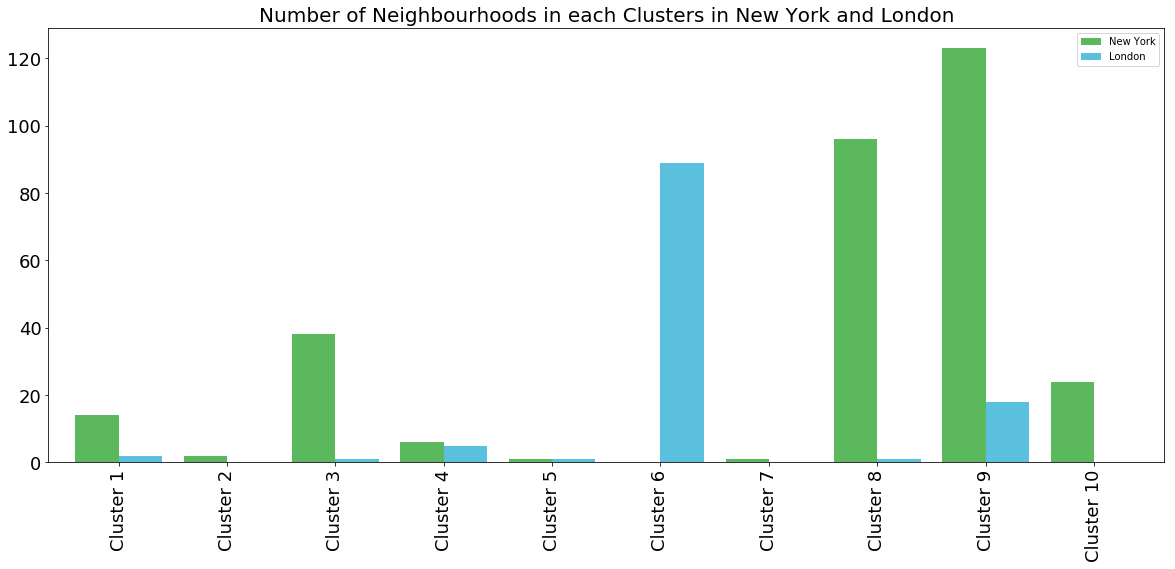

In [160]:
import matplotlib.pyplot as plt
count_nl.plot(kind='bar', 
            width=0.8, 
            figsize=(20, 8),
            color=['#5cb85c','#5bc0de'],
            fontsize=18,
            )


plt.title("Number of Neighbourhoods in each Clusters in New York and London", fontsize=20)
plt.show()